Pipeline con validación cruzada que prueba BIC, K2 y BDeu (con varios equivalent_sample_size) usando pgmpy.

Incluye:

Hill Climbing con múltiples reinicios

K-fold CV (por defecto k=5)

Evaluación en holdout con el mismo score del entrenamiento (consistente) y tabla resumen

Suavizado de parámetros al ajustar CPDs (BayesianEstimator) para evitar ceros

Opcional: listas blanca/negra de arcos (si quieres imponer causalidad obvia)

### Setup inicial

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Librerías BN
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BIC, K2, BDeu
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.readwrite import BIFWriter

# Configuración general
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (8, 6)

print("✅ Librerías cargadas correctamente")


/home/carlosbravo/Documents/MasOrange/Code/BN_Film_Recommender/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Librerías cargadas correctamente


### Cargar y preparar datos

In [2]:
# Cargar dataset
data = pd.read_csv("eleven_nodes/tv_bn_dataset.csv")

# Convertir todas las variables a categóricas (importante para BN)
for c in data.columns:
    data[c] = data[c].astype("category")

print("✅ Datos cargados y convertidos a categóricos")
display(data.head())


✅ Datos cargados y convertidos a categóricos


,GeneroUsuario,EdadUsuario,Hora,DiaSemana,DuracionPrograma,TipoEmision,InteresPrevio,GeneroPrograma,PopularidadPrograma,Satisfaccion,Recomendado
0,hombre,joven,noche,laboral,corta,bajo_demanda,noticias,noticias,baja,media,sí
1,hombre,mayor,mañana,laboral,corta,diferido,noticias,entretenimiento,alta,baja,no
2,hombre,adulto,tarde,fin_semana,corta,bajo_demanda,noticias,noticias,baja,alta,no
3,mujer,adulto,tarde,laboral,corta,directo,película,película,baja,alta,no
4,hombre,joven,tarde,laboral,corta,directo,entretenimiento,noticias,baja,alta,no


### Crar ADG inicial

In [3]:
# Relaciones base con sentido causal
base_edges = [
    ("EdadUsuario", "GeneroPrograma"),
    ("DiaSemana", "Hora"),
    ("Hora", "GeneroPrograma"),
    ("GeneroPrograma", "Satisfaccion"),
    ("Satisfaccion", "Recomendado")
]

start_model = DiscreteBayesianNetwork(base_edges)

for col in data.columns:
    if col not in start_model.nodes():
        start_model.add_node(col)

print("✅ Relaciones base definidas")
for edge in base_edges:
    print(" -", edge)


✅ Relaciones base definidas
 - ('EdadUsuario', 'GeneroPrograma')
 - ('DiaSemana', 'Hora')
 - ('Hora', 'GeneroPrograma')
 - ('GeneroPrograma', 'Satisfaccion')
 - ('Satisfaccion', 'Recomendado')


In [4]:
def learn_and_plot(data, method_name, scoring_method, start_dag=None, white_list=None, ess=None):
    hc = HillClimbSearch(data)
    model_struct = hc.estimate(scoring_method=scoring_method, start_dag=start_dag)

    # Convertir explicitamente a lista
    edges = list(model_struct.edges())

    model = DiscreteBayesianNetwork(edges)
    model.fit(data, estimator=BayesianEstimator)

    # Visualización segura
    G = nx.DiGraph()
    G.add_nodes_from(model.nodes())
    G.add_edges_from(edges)

    plt.figure(figsize=(7, 5))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue",
            font_size=10, font_weight="bold", arrowsize=20)
    title = f"{method_name}"
    if ess:
        title += f" (ESS={ess})"
    plt.title(title)
    plt.show()

    print(f"✅ {method_name}: {len(edges)} arcos aprendidos")
    return model_struct


### Baseline

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

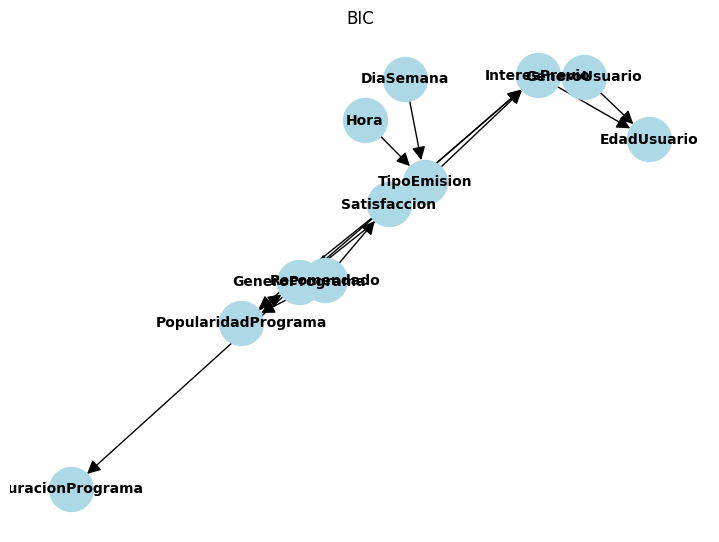

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ BIC: 14 arcos aprendidos


  0%|          | 17/1000000 [00:01<30:27:08,  9.12it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


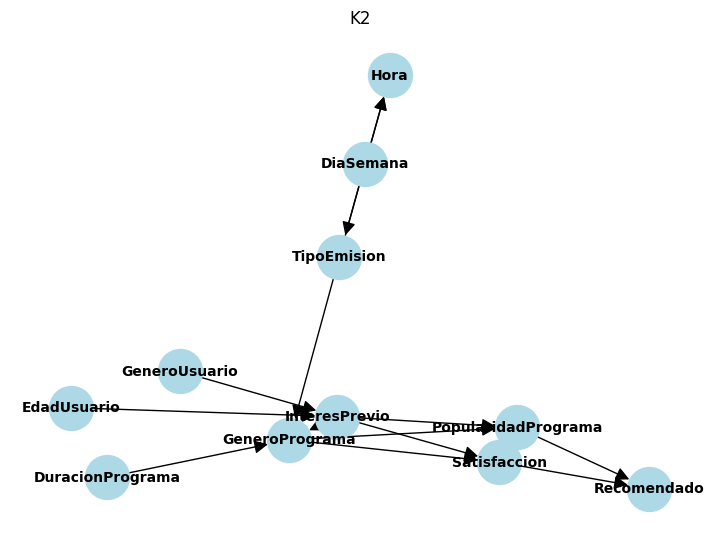

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ K2: 15 arcos aprendidos
--- equivalent_sample_size = 1 ---


  0%|          | 14/1000000 [00:01<29:23:00,  9.45it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


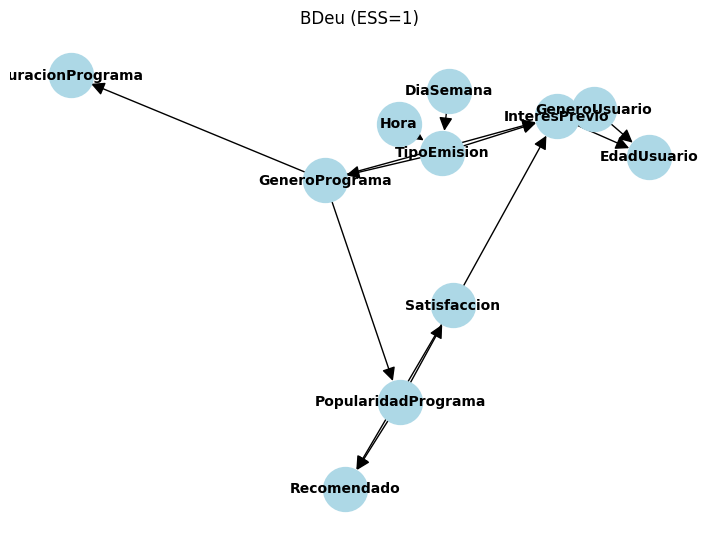

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ BDeu: 14 arcos aprendidos
--- equivalent_sample_size = 5 ---


  0%|          | 18/1000000 [00:01<27:56:02,  9.94it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


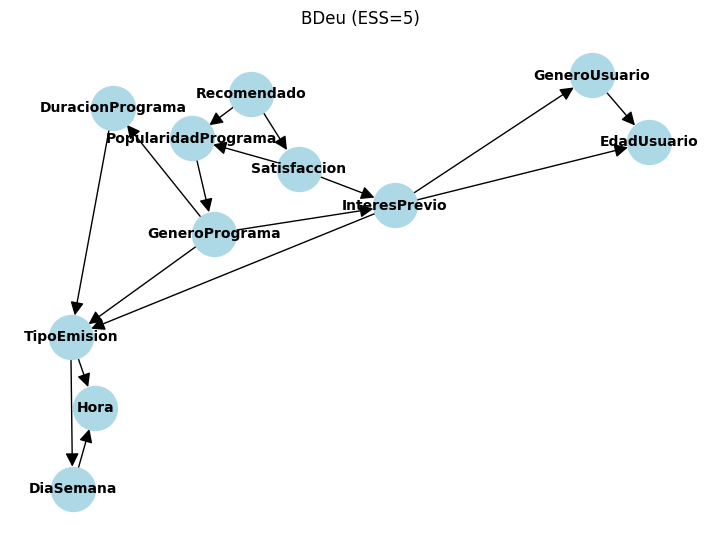

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ BDeu: 16 arcos aprendidos
--- equivalent_sample_size = 10 ---


  0%|          | 15/1000000 [00:01<28:11:40,  9.85it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


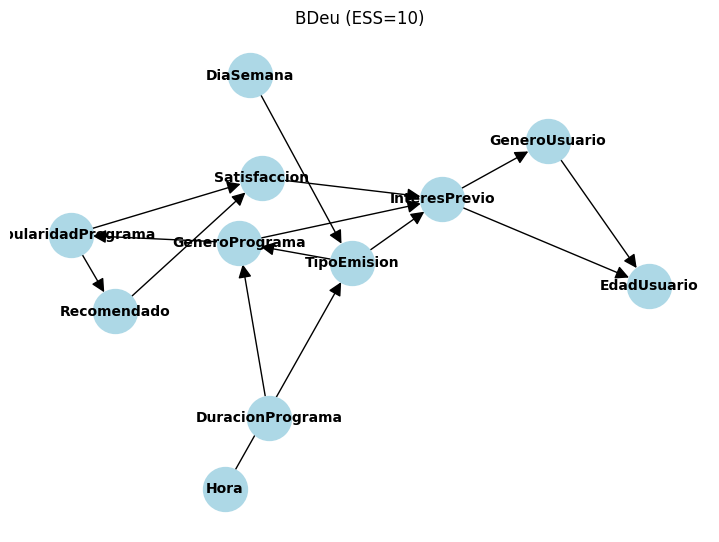

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ BDeu: 14 arcos aprendidos
--- equivalent_sample_size = 50 ---


  0%|          | 18/1000000 [00:01<24:16:17, 11.44it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


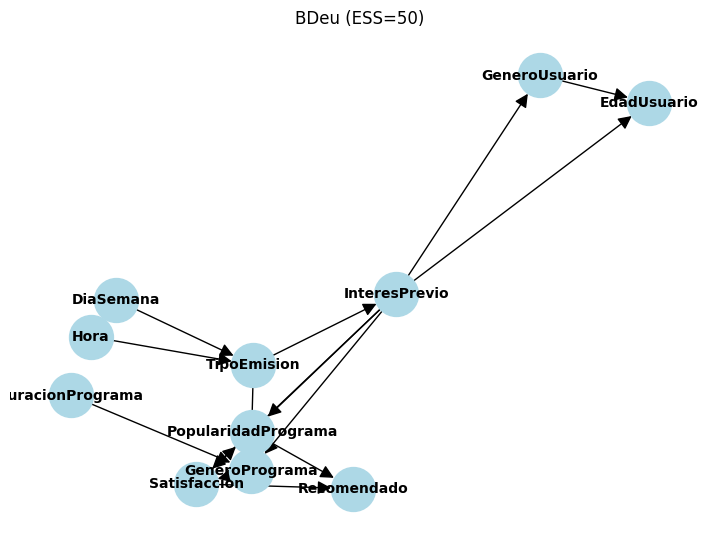

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ BDeu: 16 arcos aprendidos
--- equivalent_sample_size = 100 ---


  0%|          | 16/1000000 [00:01<26:13:23, 10.59it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


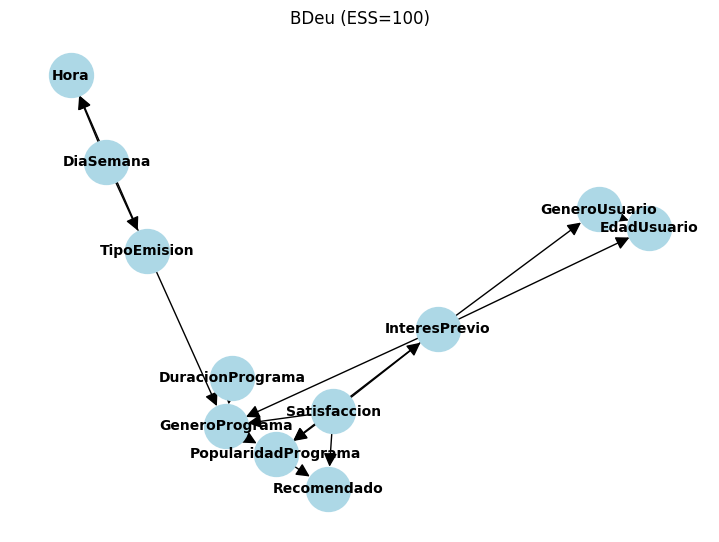

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ BDeu: 16 arcos aprendidos
--- equivalent_sample_size = 500 ---


  0%|          | 20/1000000 [00:01<24:13:15, 11.47it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


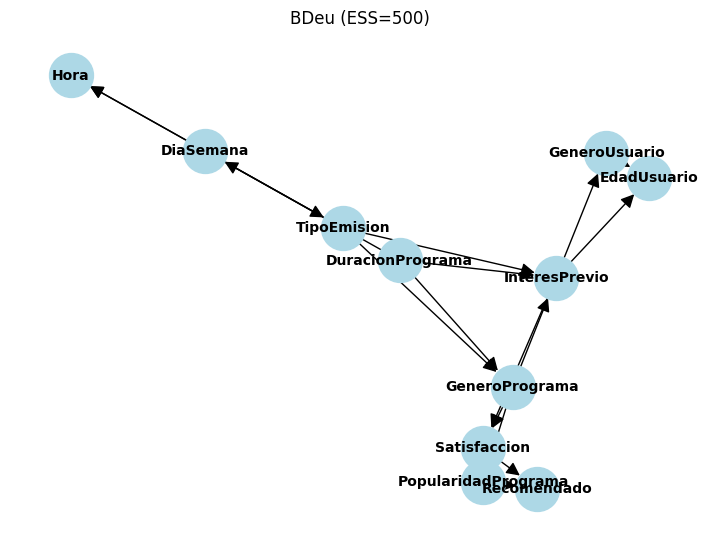

✅ BDeu: 18 arcos aprendidos


In [5]:
# 1. BIC
bic_model = learn_and_plot(data, "BIC", BIC(data))

# 2. K2
k2_model = learn_and_plot(data, "K2", K2(data))

# 3. BDeu con distintos ESS
ess_list = [1, 5, 10, 50, 100, 500]
for ess in ess_list:
    print(f"--- equivalent_sample_size = {ess} ---")
    bdeu_model = learn_and_plot(data, f"BDeu", BDeu(data, equivalent_sample_size=ess), ess=ess)


### Start_DAG

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

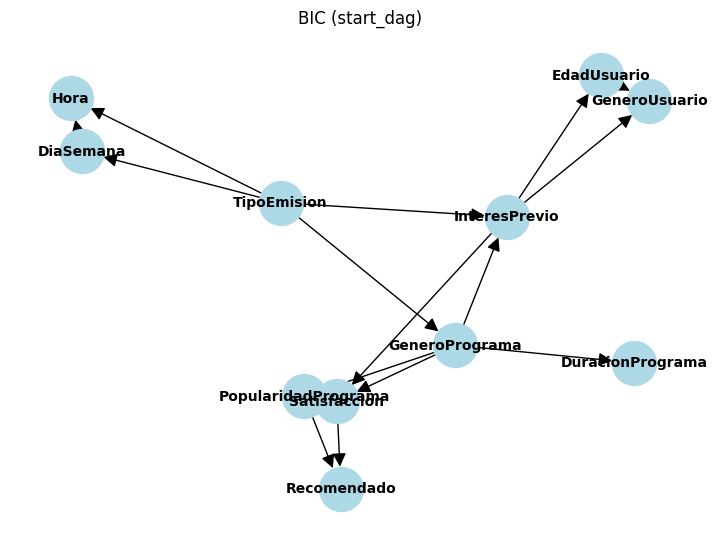

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ BIC (start_dag): 16 arcos aprendidos


  0%|          | 8/1000000 [00:01<38:24:27,  7.23it/s] 
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


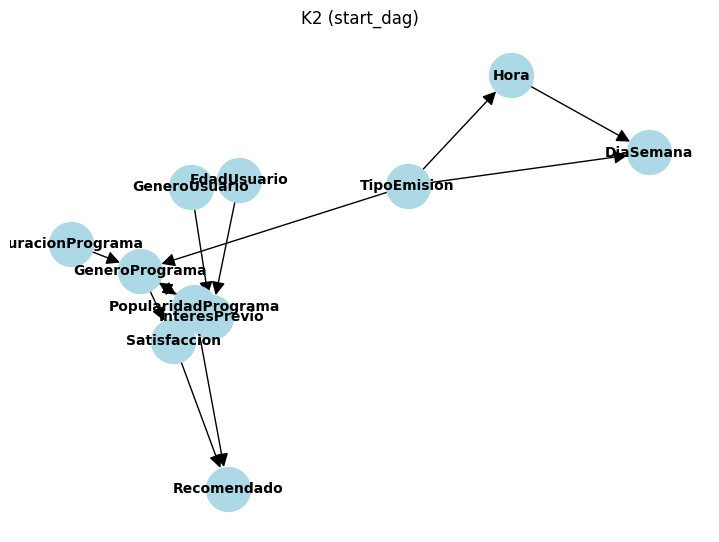

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ K2 (start_dag): 14 arcos aprendidos
--- equivalent_sample_size = 1 ---


  0%|          | 1/1000000 [00:00<190:25:33,  1.46it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


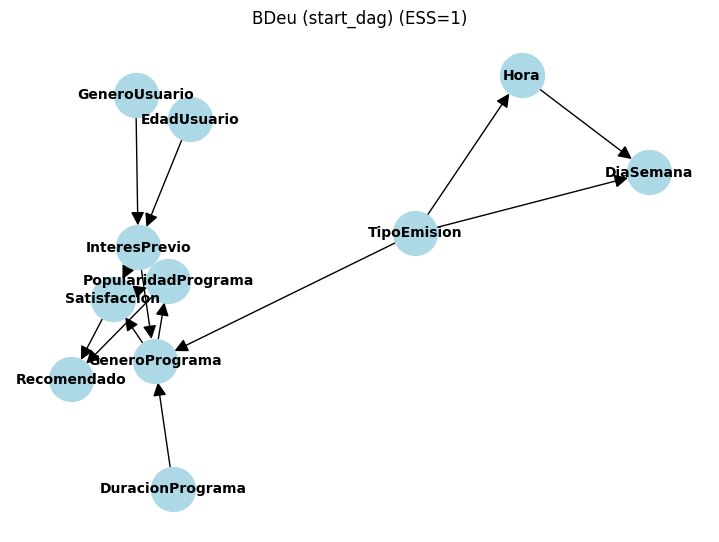

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ BDeu (start_dag): 14 arcos aprendidos
--- equivalent_sample_size = 5 ---


  0%|          | 1/1000000 [00:00<203:29:46,  1.37it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


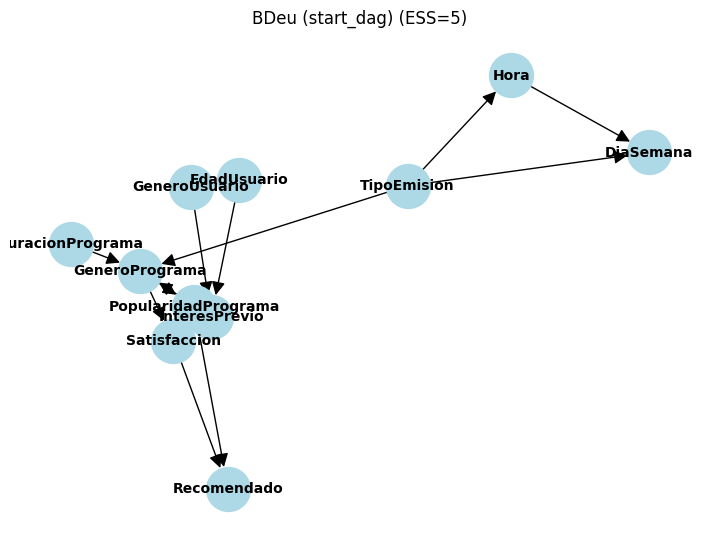

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ BDeu (start_dag): 14 arcos aprendidos
--- equivalent_sample_size = 10 ---


  0%|          | 0/1000000 [00:00<?, ?it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


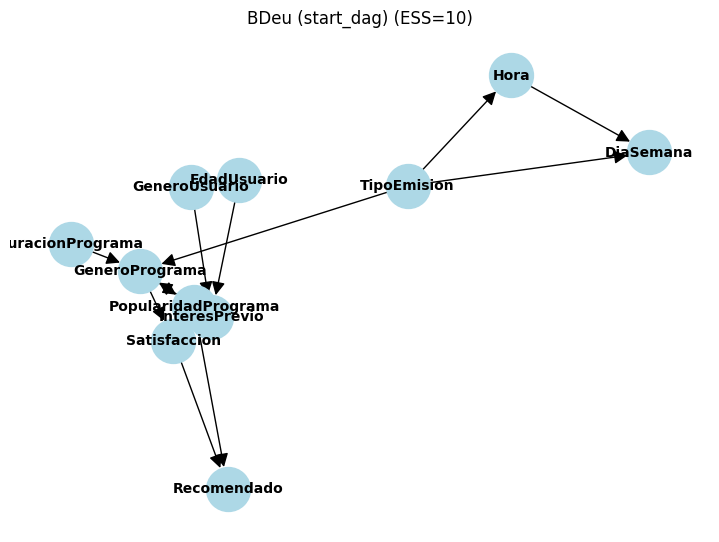

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ BDeu (start_dag): 14 arcos aprendidos
--- equivalent_sample_size = 50 ---


  0%|          | 0/1000000 [00:00<?, ?it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


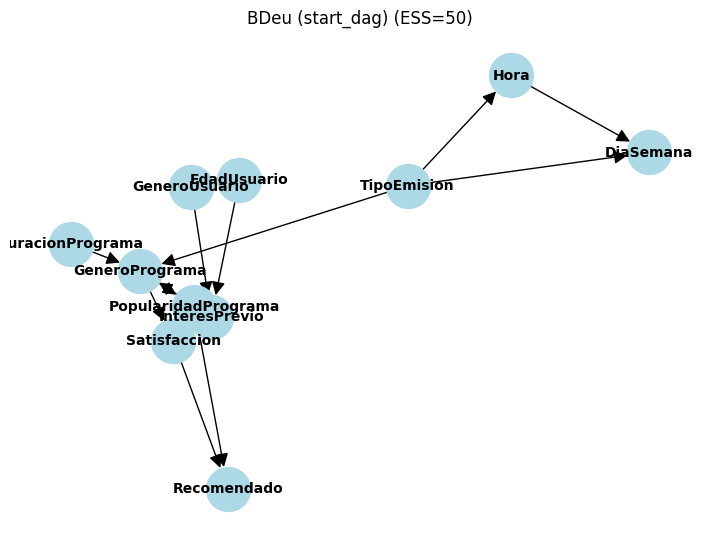

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ BDeu (start_dag): 14 arcos aprendidos
--- equivalent_sample_size = 100 ---


  0%|          | 0/1000000 [00:00<?, ?it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


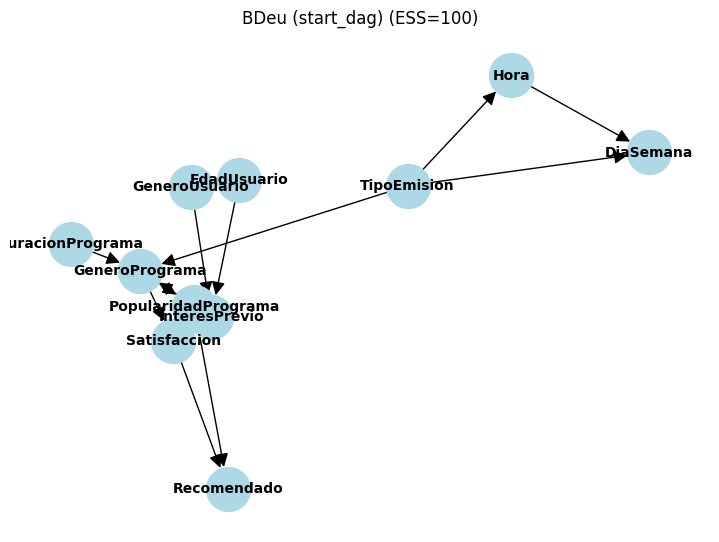

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recom

✅ BDeu (start_dag): 14 arcos aprendidos
--- equivalent_sample_size = 500 ---


  0%|          | 2/1000000 [00:00<85:10:23,  3.26it/s] 
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}


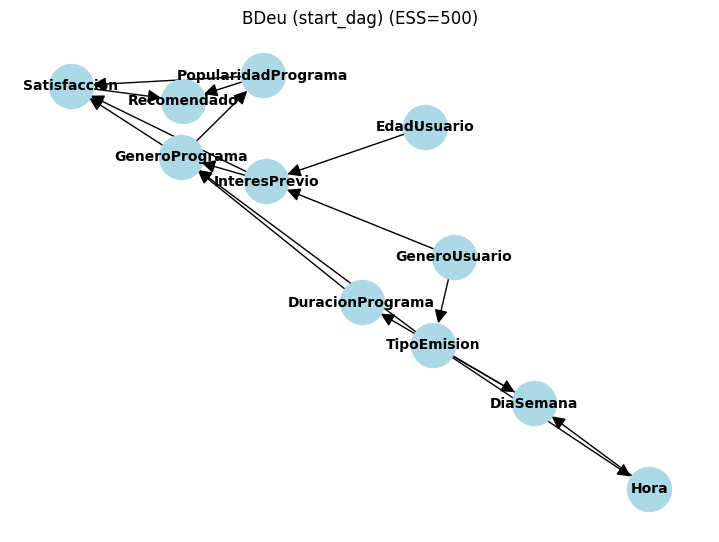

✅ BDeu (start_dag): 16 arcos aprendidos


In [6]:
# 1. BIC
bic_start = learn_and_plot(data, "BIC (start_dag)", BIC(data), start_dag=start_model)

# 2. K2
k2_start = learn_and_plot(data, "K2 (start_dag)", K2(data), start_dag=start_model)

# 3. BDeu
for ess in ess_list:
    print(f"--- equivalent_sample_size = {ess} ---")
    bdeu_start = learn_and_plot(data, f"BDeu (start_dag)", BDeu(data, equivalent_sample_size=ess), start_dag=start_model, ess=ess)
